In [1]:
from IPython.display import FileLink, Image
import pandas as pd
import pandas.rpy.common as com
import brewer2mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib import gridspec
from matplotlib import collections
from numpy import nan, min, array
import itertools
from mpltools import style
style.use("ggplot")
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0), physeq)
print(physeq.PE)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10361 taxa and 395 samples ]
sample_data() Sample Data:       [ 395 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 10361 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10361 tips and 10360 internal nodes ]


In [4]:
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["axes.edgecolor"] = "#151515"
matplotlib.rcParams["grid.color"] = "#959595"
matplotlib.rcParams["grid.alpha"] = "0.75"
matplotlib.rcParams["font.size"] = 7.5

In [35]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Dark2", "Set1", "Accent"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, treatment):
    min_padj = l2fc_df[["OTU","padj","Treatment"]].groupby(["Treatment","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[treatment]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
    
    days = map(str,[14,28,45])
    scaleFactor = 0.125
    
    cell000_rspdrs = get_responders(l2fc_df, "13C000")
    cell700_rspdrs = get_responders(l2fc_df, "13C700")
    cell100_rspdrs = get_responders(l2fc_df, "13C100")

    df_pivot = l2fc_df.pivot_table(rows=["y"], cols=["Treatment","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 30]))

    gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[9,5.25,4,4,4])

    fig = plt.figure()
    fig.set_size_inches((7,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap

    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1), 
                                                alpha=0.8)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    ax1.set_title(taxon, fontdict = {"fontsize": 14})

    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in cell000_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in cell700_rspdrs)
    criterion4 = tip_df["OTU"].map(lambda x: x in cell100_rspdrs)
    cell000_rspndrs_tips = tip_df[criterion2]
    cell700_rspndrs_tips = tip_df[criterion3]
    cell100_rspndrs_tips = tip_df[criterion4]
    ax2.scatter(x = [1 for i in cell000_rspndrs_tips.y], 
                y = cell000_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#99CC00")
    ax2.scatter(x = [2 for i in cell700_rspndrs_tips.y], 
                y = cell700_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#CC0033")
    ax2.scatter(x = [3 for i in cell100_rspndrs_tips.y], 
                y = cell100_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#009999")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,4])
    ax2.set_xticks([1,2,3])
    ax2.set_xticklabels(["Cellulose Only","RE.Pulse","RE.Continuous"], rotation = 90, size = 12)
    ax2.set_yticks([])
    
    vmin = l2fc_df["log2FoldChange"].quantile(0.025)
    vmax = l2fc_df["log2FoldChange"].quantile(0.975)

    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_xticks(range(len(days)))
    ax3.set_xticklabels(days, size = 12)
    ax3.set_yticklabels([])
    ax3.set_title("Cellulose Only", rotation = 45, va = 'bottom', ha = 'left')
    ax3.set_xlabel("Day", size = 12)
    df = df_pivot["13C000"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[3], sharey = ax1)
    ax4.set_xticks(range(len(days)))
    ax4.set_xticklabels(days, size = 12)
    ax4.set_yticklabels([])
    ax4.set_title("RE.Pulse", rotation = 45, va = 'bottom', ha = 'left')
    ax4.set_xlabel("Day", size = 12)
    df = df_pivot["13C700"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)
    
    ax5 = fig.add_subplot(gs[4], sharey = ax1)
    ax5.set_xticks(range(len(days)))
    ax5.set_xticklabels(days, size = 12)
    ax5.set_yticklabels([])
    ax5.set_title("RE.Continuous", rotation = 45, va = 'bottom', ha = 'left')
    ax5.set_xlabel("Day", size = 12)
    df = df_pivot["13C100"]
    ax5.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax5.grid(False)

    box = ax5.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.03, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"Log$_{2}$ Fold Change", size = 12)

    proxy_artists = [plt.Rectangle((0,0),1,1,1,fc=tax_colors[i]) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':12,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

Joining by: "OTU"


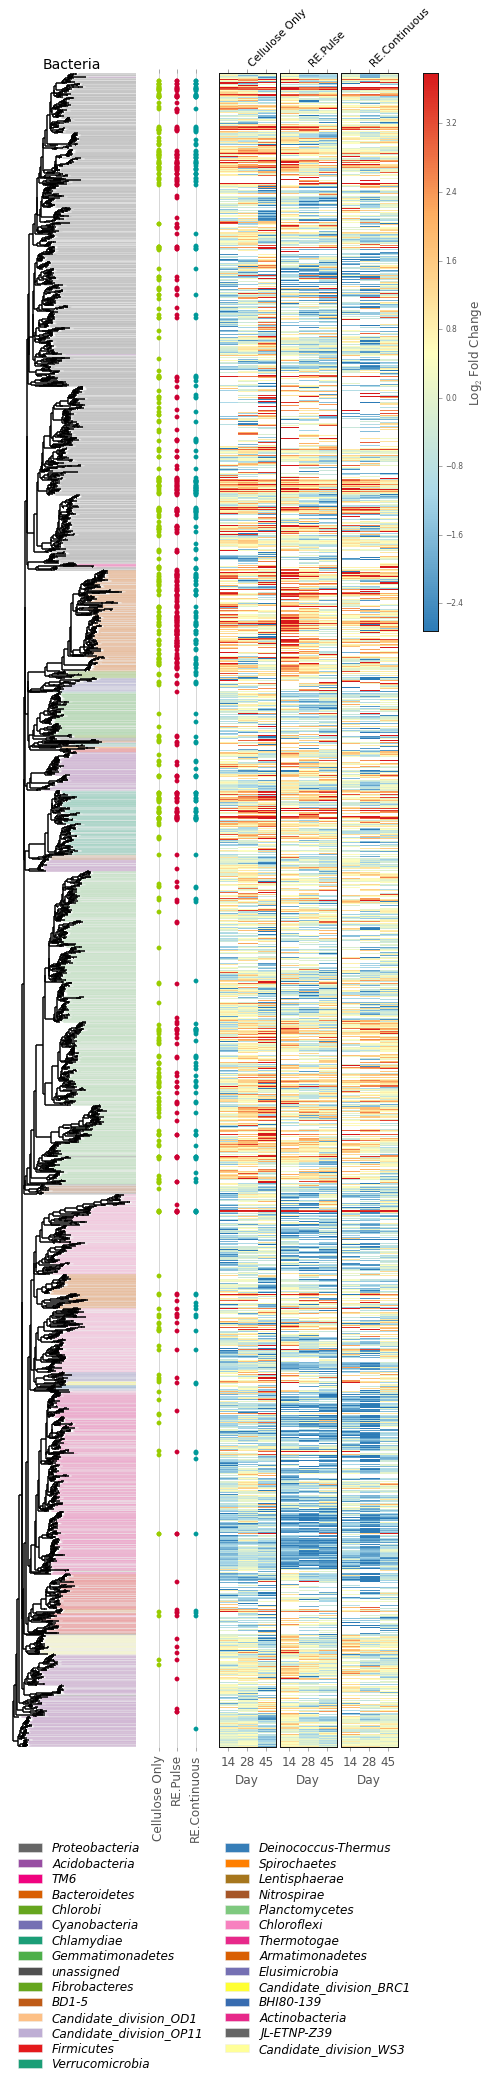

In [36]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "/var/seq_data/priming_exp/data/l2fc_table.csv", "physeq.PE", 
              save_fn = "figs/bacteria_tree.pdf", lw_tax = 1, leg_spacing = 0.05,
              pt_size = 18)

In [37]:
FileLink("figs/bacteria_tree.pdf")

/home/ashley/priming_exp/figs/bacteria_tree.pdf

Joining by: "OTU"


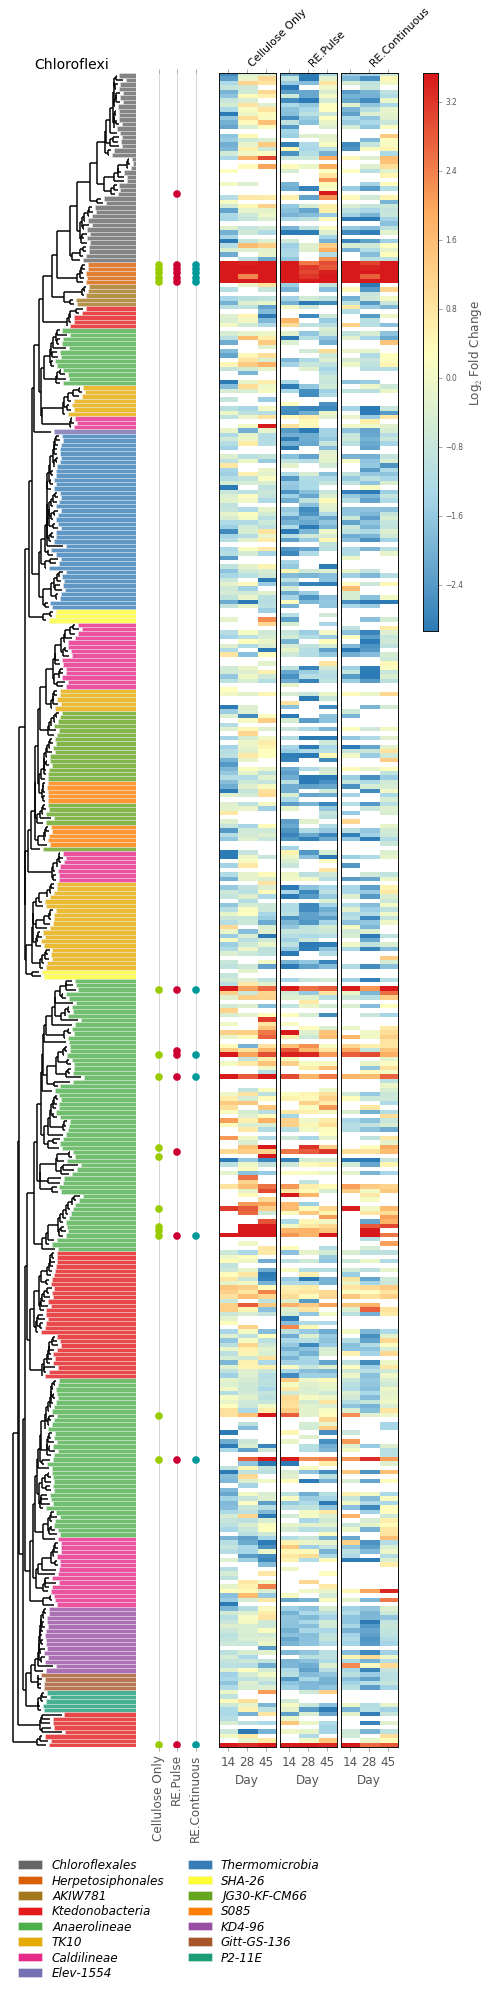

In [38]:
make_tree_fig("Chloroflexi", "Rank2", "Rank3", "/var/seq_data/priming_exp/data/l2fc_table.csv", "physeq.PE", 
              save_fn="figs/chloroflexi_tree.pdf", leg_spacing = 0.06)

In [29]:
FileLink("figs/chloroflexi_tree.pdf")

/home/ashley/priming_exp/figs/chloroflexi_tree.pdf

Joining by: "OTU"


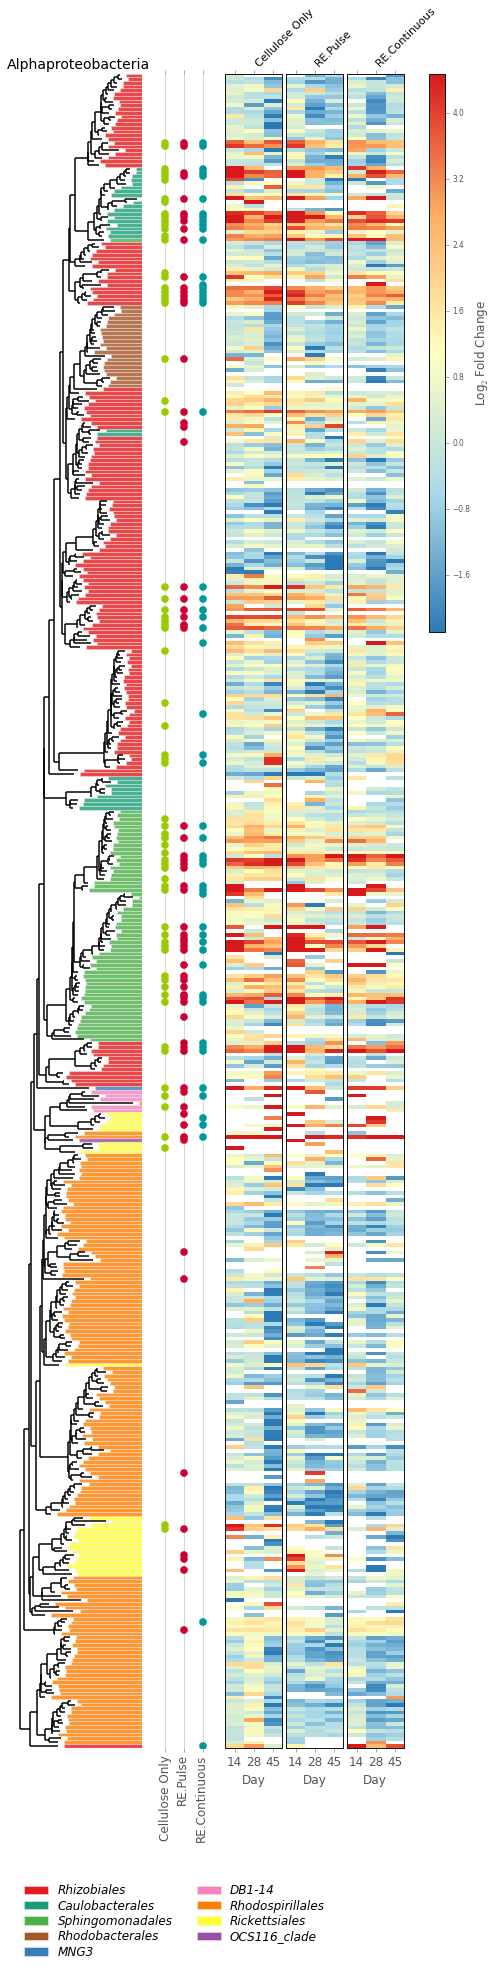

In [30]:
make_tree_fig("Alphaproteobacteria", "Rank3", "Rank4", "/var/seq_data/priming_exp/data/l2fc_table.csv", "physeq.PE", 
               save_fn = "figs/alphaproteo_tree.pdf", leg_spacing = 0.075)

In [31]:
FileLink("figs/alphaproteo_tree.pdf")

/home/ashley/priming_exp/figs/alphaproteo_tree.pdf

Joining by: "OTU"


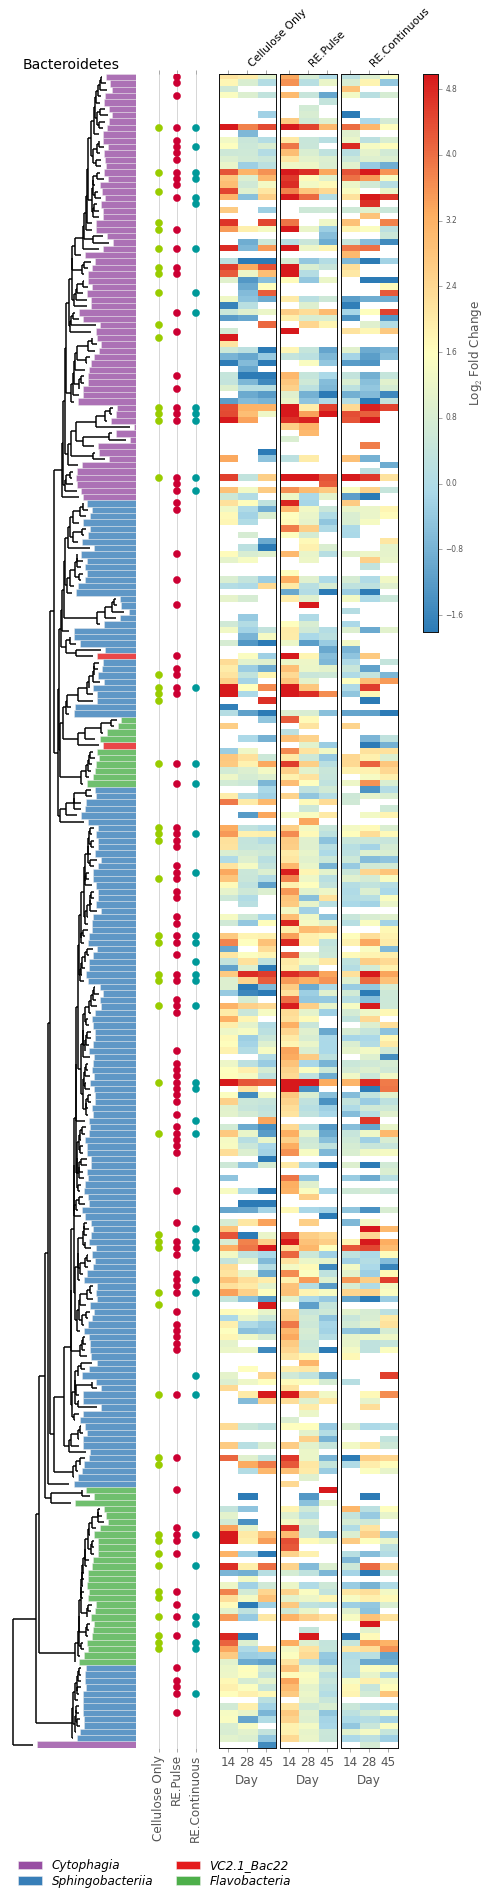

In [32]:
make_tree_fig("Bacteroidetes", "Rank2", "Rank3", "/var/seq_data/priming_exp/data/l2fc_table.csv", "physeq.PE",
              save_fn = "figs/bacteroidetes_tree.pdf", leg_spacing = 0.06)

In [33]:
FileLink("figs/bacteroidetes_tree.pdf")

/home/ashley/priming_exp/figs/bacteroidetes_tree.pdf

Joining by: "OTU"


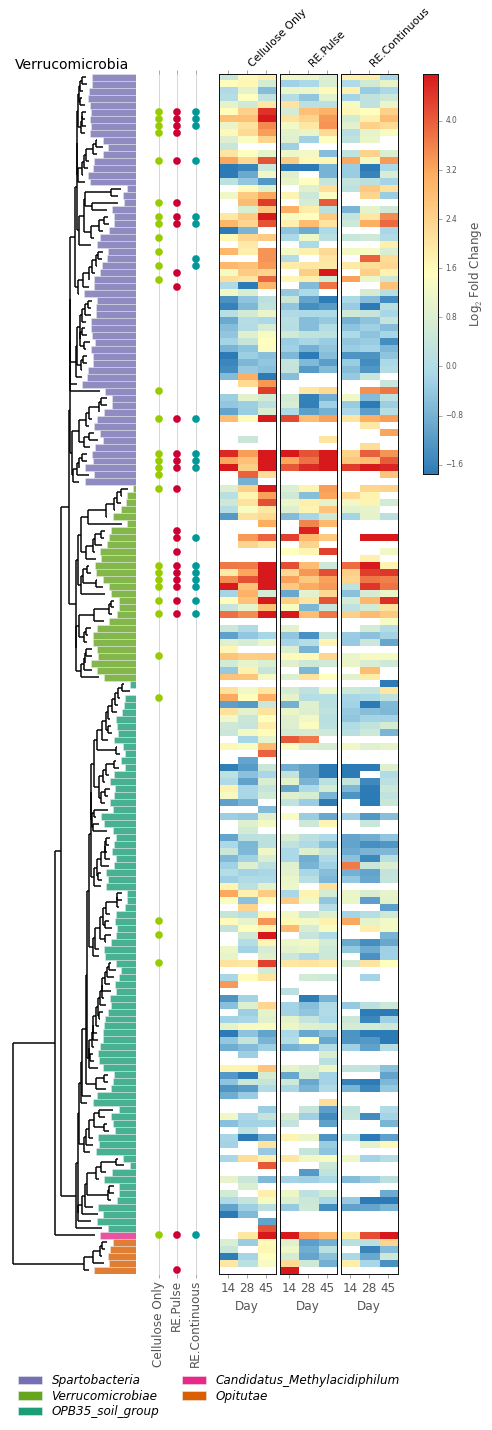

In [39]:
make_tree_fig("Verrucomicrobia", "Rank2", "Rank3", "/var/seq_data/priming_exp/data/l2fc_table.csv", "physeq.PE", 
              save_fn = "figs/verrucomicrobia_tree.pdf", leg_spacing = 0.075)

In [15]:
FileLink("figs/verrucomicrobia_tree.pdf")

/home/ashley/priming_exp/figs/verrucomicrobia_tree.pdf